In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the data
meth = pd.read_csv('/content/1_te.csv')

# Normalize the data
scaler = StandardScaler()
meth_scaled = scaler.fit_transform(meth)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))

    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)

    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation

    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = meth_scaled.shape[1]
autoencoder = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full dataset
history = autoencoder.fit(
    meth_scaled,
    meth_scaled,
    epochs=2000,
    batch_size=64,
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss = history.history['loss'][-1]
print(f'Training loss: {train_loss}')


Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2908 - learning_rate: 1.0000e-04
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2960 - learning_rate: 1.0000e-04
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2968 - learning_rate: 1.0000e-04
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2998 - learning_rate: 9.9999e-05
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2889 - learning_rate: 9.9999e-05
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2914 - learning_rate: 9.9998e-05
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2867 - learning_rate: 9.9997e-05
Epoch 9/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2851 - learning_rate: 9.9996e-05
Epoch 10/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2842 - learning_rate: 9.9996e-05
Epoch 11/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


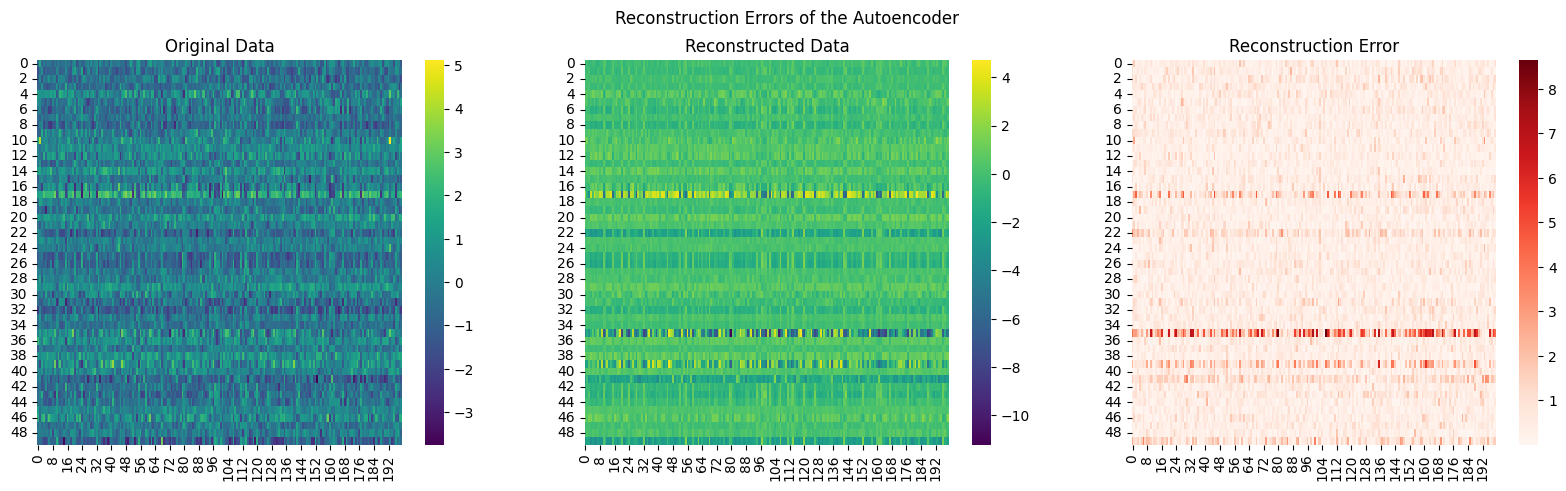

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the reconstructed data from the autoencoder
X_reconstructed = autoencoder.predict(meth_scaled)

# Calculate reconstruction errors (absolute difference between original and reconstructed data)
reconstruction_errors = np.abs(meth_scaled - X_reconstructed)

# Define a function to plot the combined heatmaps
def plot_combined_heatmaps(original, reconstructed, errors, title):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the heatmap for the original data
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis')
    axes[0].set_title('Original Data')

    # Plot the heatmap for the reconstructed data
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis')
    axes[1].set_title('Reconstructed Data')

    # Plot the heatmap for the reconstruction error
    sns.heatmap(errors[:50], ax=axes[2], cmap='Reds')
    axes[2].set_title('Reconstruction Error')

    # Set the main title for the entire plot
    plt.suptitle(title)

    # Display the plot
    plt.show()

# Plot the heatmaps for the first 50 samples of each dataset
plot_combined_heatmaps(meth_scaled, X_reconstructed, reconstruction_errors, 'Reconstruction Errors of the Autoencoder')


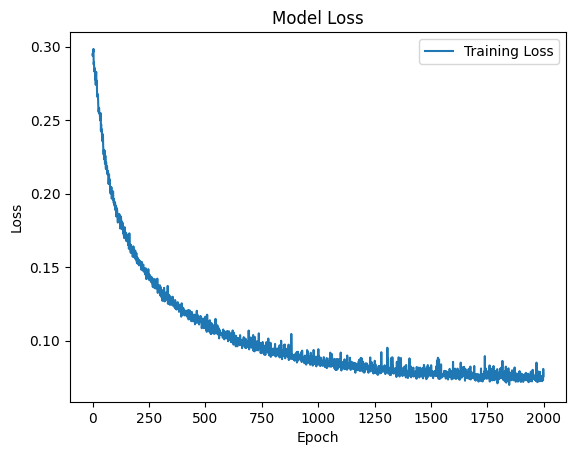

In [3]:
import matplotlib.pyplot as plt

def plot_loss(history):

    plt.plot(history.history['loss'], label='Training Loss')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


plot_loss(history)


In [4]:
# Reconstruct the test data (using the trained autoencoder)
X_reconstructed = autoencoder.predict(meth_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#X_reconstructed_original = scaler.inverse_transform(X_reconstructed)

# Save the reconstructed dataset to a CSV file
reconstructed_df = pd.DataFrame(X_reconstructed, columns=meth.columns)
reconstructed_df.to_csv('reconstructed_meth_1tr.csv', index=False)

print("Reconstructed dataset saved to 'reconstructed_meth.csv'.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Reconstructed dataset saved to 'reconstructed_meth.csv'.


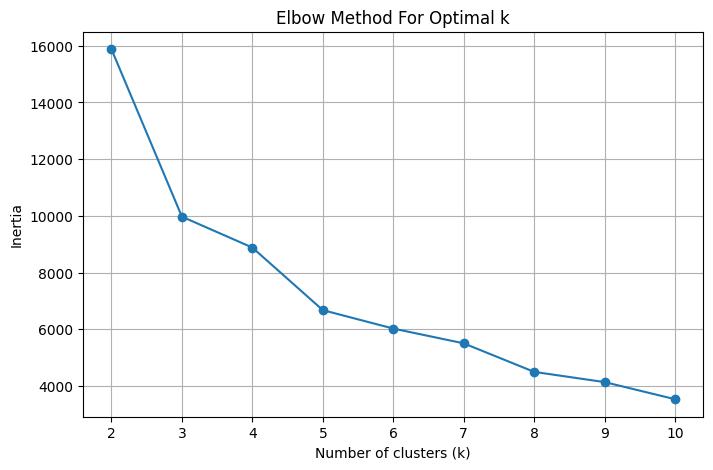

In [8]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('/content/reconstructed_meth_1tr.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


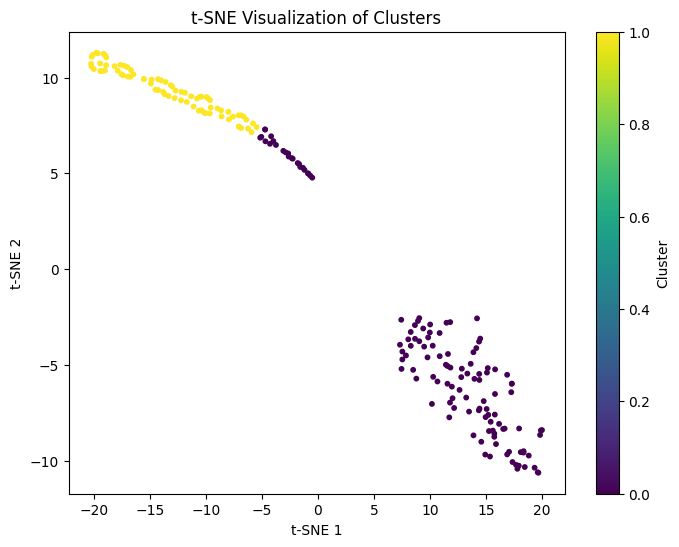


Cluster Counts:
 Cluster
0    125
1     77
Name: count, dtype: int64
Silhouette Score: 0.5539
Davies-Bouldin Score: 0.6929
Calinski-Harabasz Score: 310.873


In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load your data (replace with your actual data loading)
# Example: df = pd.read_csv('your_file.csv')
# Here we assume 'df' is already available

# Step 2: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

# Step 3: Choose the number of clusters (manually or using elbow method)
chosen_k = 2  # Adjust if needed

# Step 4: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 5: Apply SMOTE using pseudo-labels (set k_neighbors=1 to avoid small sample issue)
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 6: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 7: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Step 8: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 9: Internal validation metrics (unsupervised)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

# Show results
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))


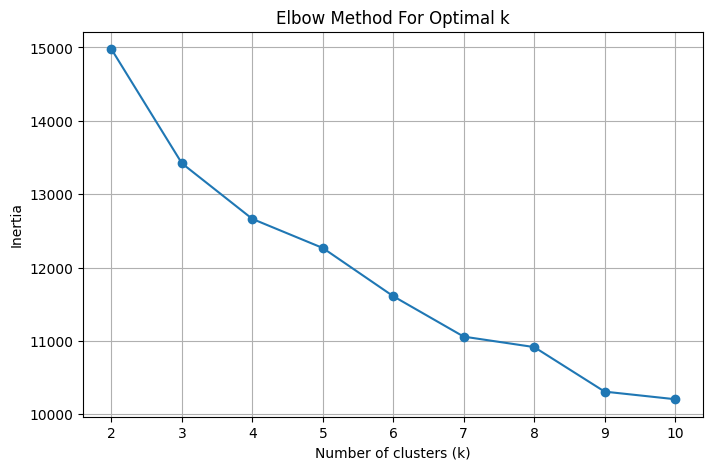

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('/content/1_te.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


   6.999883177967922143e-02  1.713576083221808877e-01  \
0                 -0.701723                  1.614739   
1                 -1.701847                 -0.360800   
2                 -1.365279                  0.469812   
3                 -0.934232                 -0.880068   
4                  1.027378                  0.890523   

   5.011166302604544431e-02  4.834501703339517675e-01  \
0                 -0.840308                 -0.201104   
1                  0.607102                 -1.442400   
2                 -1.445695                 -0.086844   
3                  0.795943                 -0.946051   
4                  0.780551                  0.774229   

   2.839510685700721293e-01  3.371600643017752530e-01  \
0                 -0.758224                 -0.053310   
1                 -0.857510                 -1.250248   
2                 -0.422254                  0.043348   
3                 -1.138427                 -1.739166   
4                  1.131512  

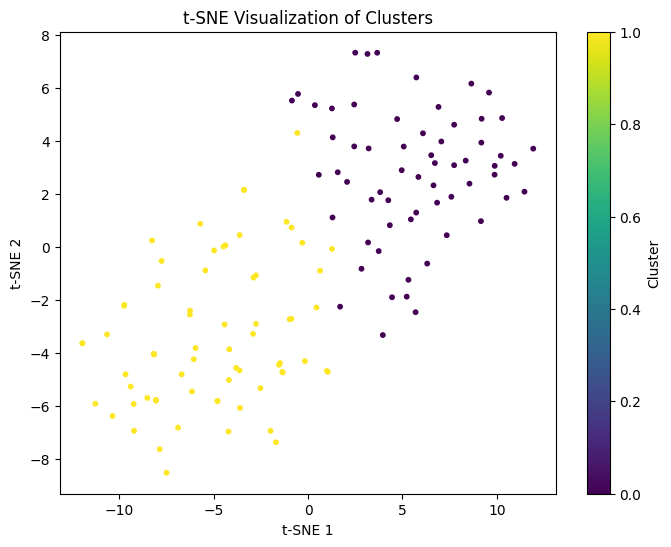


Internal Validation Metrics:
Silhouette Score: 0.2477
Davies-Bouldin Score: 1.482
Calinski-Harabasz Score: 55.1313

Top Biomarker Candidates (based on Kruskal-Wallis test):
                      Feature    ANOVA_pval  Kruskal_pval
128  5.248828689966622552e-01  4.877730e-26  5.446211e-20
138  5.997184389359950796e-01  2.923528e-25  1.038548e-19
5    3.371600643017752530e-01  2.659087e-24  2.651342e-19
9    5.408901800057888121e-01  3.047867e-24  3.141248e-19
38   8.406748925072650147e-01  7.177922e-23  3.880296e-19
0    6.999883177967922143e-02  1.066417e-21  1.012064e-17
3    4.834501703339517675e-01  1.218823e-23  1.403635e-17
148  2.282475788005146888e-01  5.720755e-22  1.646662e-17
100  2.423546118210627986e-01  9.080444e-19  1.818769e-17
123  4.392265644817887060e-01  2.585007e-22  3.007437e-17
57   4.256779069755897704e-01  1.385197e-21  3.389946e-17
82   3.721785178948133765e-01  1.326672e-21  9.118435e-17
50   4.193951110161528995e-01  9.678834e-20  2.825563e-16
137  3.4617082

/tmp/ipython-input-2109771919.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Cluster'] = result_df['Cluster'].values


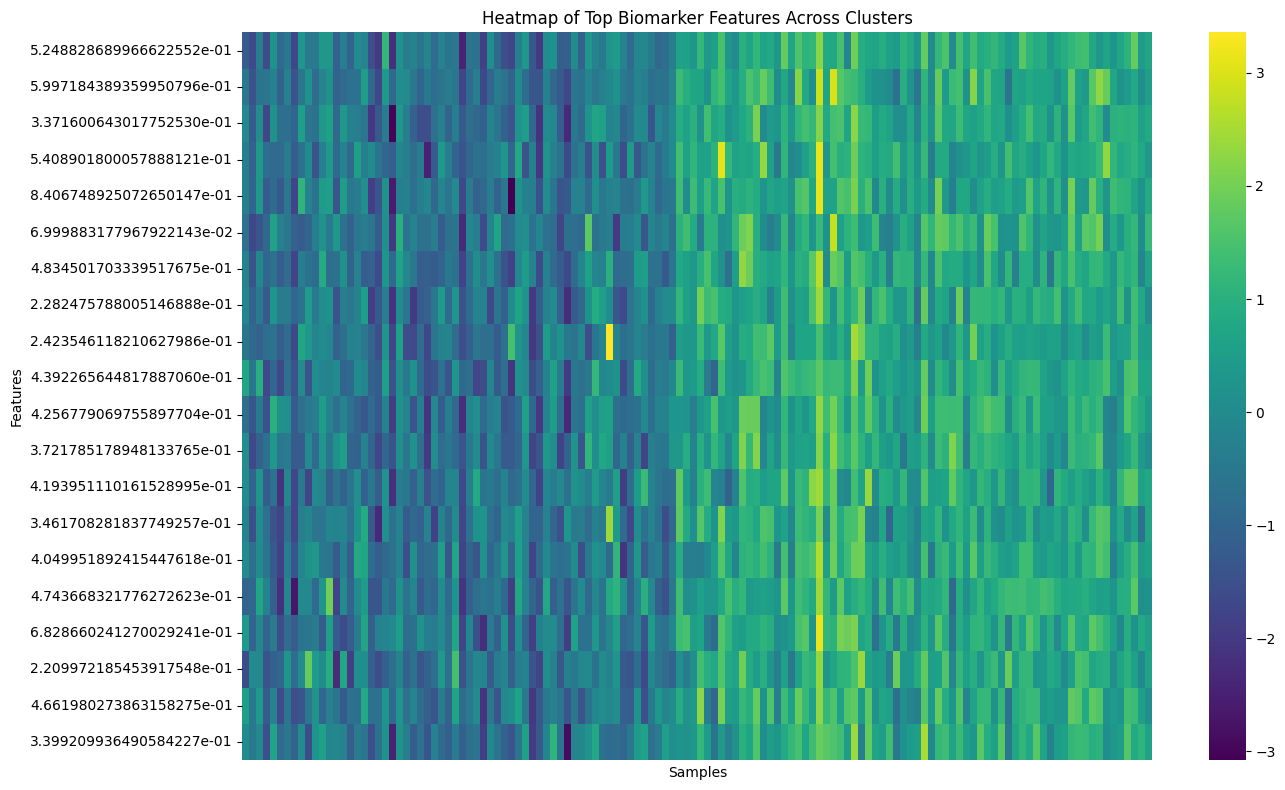

In [12]:
# Step 4: Choose number of clusters
chosen_k = 2  # adjust based on elbow plot

# Step 5: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 6: Apply SMOTE on pseudo-labels
smote = SMOTE(random_state=42)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 7: Final clustering on SMOTE data
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 8: Create DataFrame with biological feature names and cluster labels
result_df = pd.DataFrame(X_smote, columns=df.columns)  # preserve real feature names here
result_df['Cluster'] = final_clusters

print(result_df.head())
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())

# Step 9: t-SNE visualization of clusters
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 10: Internal cluster validation scores
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

print("\nInternal Validation Metrics:")
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))

# Step 11: Biomarker discovery (differential features across clusters)
X_biomarker = result_df.drop('Cluster', axis=1).values
y_clusters = result_df['Cluster'].values

anova_pvals = []
kruskal_pvals = []

for i in range(X_biomarker.shape[1]):
    groups = [X_biomarker[y_clusters == c, i] for c in np.unique(y_clusters)]

    # ANOVA
    try:
        _, p_anova = f_oneway(*groups)
    except:
        p_anova = 1.0
    anova_pvals.append(p_anova)

    # Kruskal-Wallis
    try:
        _, p_kruskal = kruskal(*groups)
    except:
        p_kruskal = 1.0
    kruskal_pvals.append(p_kruskal)

biomarker_df = pd.DataFrame({
    'Feature': df.columns,  # use original biological names here
    'ANOVA_pval': anova_pvals,
    'Kruskal_pval': kruskal_pvals
})

biomarker_df.sort_values('Kruskal_pval', inplace=True)

print("\nTop Biomarker Candidates (based on Kruskal-Wallis test):")
print(biomarker_df.head(20))

# Step 12: Print only top biomarker names
top_n = 20
top_biomarkers = biomarker_df.head(top_n)['Feature'].values

print("\nTop Biomarker Feature Names:")
for name in top_biomarkers:
    print(name)

# Step 13: Heatmap of top biomarkers across samples sorted by cluster
top_features = biomarker_df.head(top_n)['Feature'].values
heatmap_data = result_df[top_features]
heatmap_data['Cluster'] = result_df['Cluster'].values
heatmap_data_sorted = heatmap_data.sort_values('Cluster')
cluster_labels = heatmap_data_sorted['Cluster']
heatmap_data_sorted = heatmap_data_sorted.drop('Cluster', axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data_sorted.T, cmap='viridis', cbar=True, xticklabels=False)
plt.title("Heatmap of Top Biomarker Features Across Clusters")
plt.xlabel("Samples")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# mRNA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the mRNA data
mRNA = pd.read_csv('/content/2_te.csv')

# Normalize the data
scaler = StandardScaler()
mRNA_scaled = scaler.fit_transform(mRNA)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))

    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)

    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation

    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = mRNA_scaled.shape[1]
autoencoder = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full mRNA dataset
history_mRNA = autoencoder.fit(
    mRNA_scaled,
    mRNA_scaled,
    epochs=2000,
    batch_size=64,
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss_mRNA = history_mRNA.history['loss'][-1]
print(f'Training loss for mRNA dataset: {train_loss_mRNA}')


Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.2949 - learning_rate: 1.0000e-04
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2943 - learning_rate: 1.0000e-04
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2981 - learning_rate: 1.0000e-04
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2946 - learning_rate: 1.0000e-04
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2968 - learning_rate: 9.9999e-05
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2971 - learning_rate: 9.9999e-05
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2989 - learning_rate: 9.9998e-05
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2881 - learning_rate: 9.9997e-05
Epoch 9/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2908 - learning_rate: 9.9996e-05
Epoch 10/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2846 - learning_rate: 9.9996e-05
Epoch 11/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


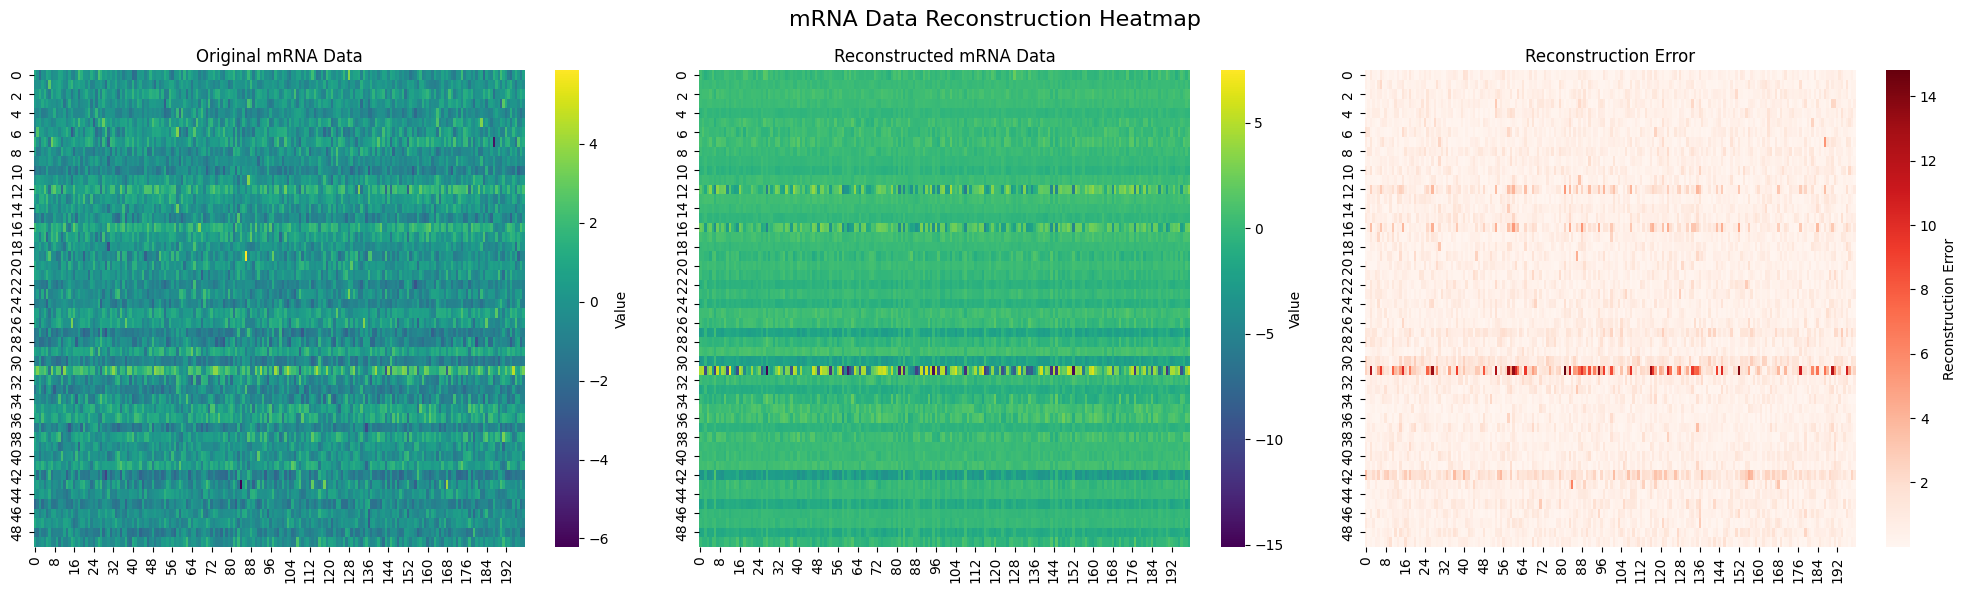

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the data using the trained autoencoder
mRNA_reconstructed = autoencoder.predict(mRNA_scaled)

# Convert the reconstructed data back to the original scale
#mRNA_reconstructed_original = scaler.inverse_transform(mRNA_reconstructed)

# Calculate the reconstruction error (absolute error between original and reconstructed data)
reconstruction_error = np.abs(mRNA_scaled - mRNA_reconstructed)

def plot_combined_heatmaps(original, reconstructed, error, title):
    # Plot the first 50 samples for visualization (adjust as needed)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Heatmap for Original Data
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis', cbar_kws={'label': 'Value'})
    axes[0].set_title('Original mRNA Data')

    # Heatmap for Reconstructed Data
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis', cbar_kws={'label': 'Value'})
    axes[1].set_title('Reconstructed mRNA Data')

    # Heatmap for Reconstruction Error
    sns.heatmap(error[:50], ax=axes[2], cmap='Reds', cbar_kws={'label': 'Reconstruction Error'})
    axes[2].set_title('Reconstruction Error')

    # Overall title and layout adjustments
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot heatmaps for original, reconstructed data, and reconstruction error
plot_combined_heatmaps(mRNA_scaled, mRNA_reconstructed, reconstruction_error, 'mRNA Data Reconstruction Heatmap')


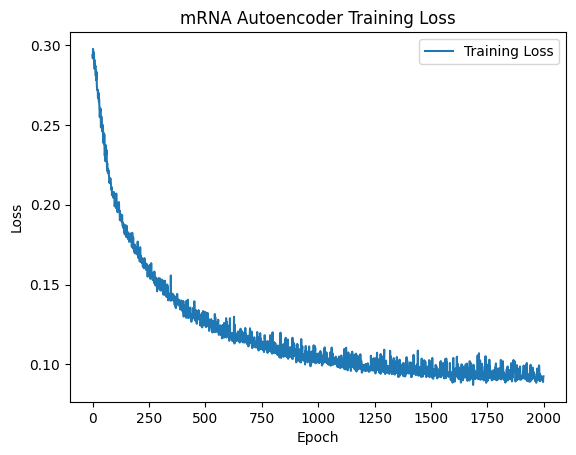

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_mRNA(history_mRNA):
    # Plot the training loss
    plt.plot(history_mRNA.history['loss'], label='Training Loss')

    plt.title('mRNA Autoencoder Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot the training loss for the mRNA dataset
plot_loss_mRNA(history_mRNA)


In [ ]:
# Reconstruct the mRNA data using the trained autoencoder
mRNA_reconstructed = autoencoder.predict(mRNA_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#mRNA_reconstructed_original = scaler.inverse_transform(mRNA_reconstructed)

# Save the reconstructed mRNA dataset to a CSV file
reconstructed_mRNA_df = pd.DataFrame(mRNA_reconstructed, columns=mRNA.columns)
reconstructed_mRNA_df.to_csv('reconstructed_mRNA_2te.csv', index=False)

print("Reconstructed mRNA dataset saved to 'reconstructed_mRNA.csv'.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Reconstructed mRNA dataset saved to 'reconstructed_mRNA.csv'.


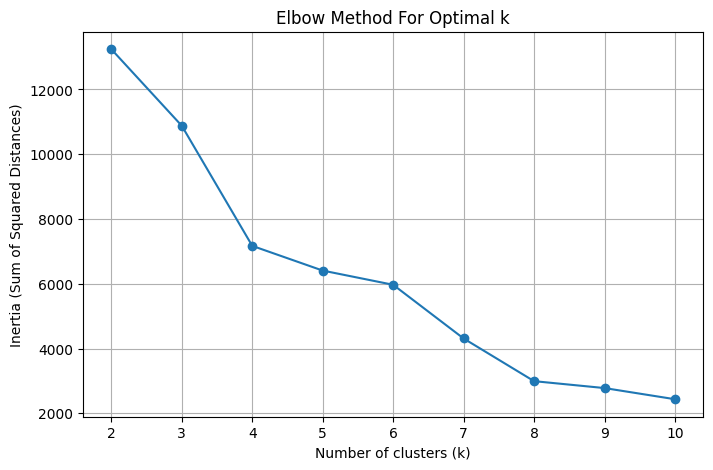

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load your biological unlabeled data
df = pd.read_csv('reconstructed_mRNA_2te.csv')  # Make sure this file has no missing values
X = df.values

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Plot the Elbow Method to find optimal n_clusters
inertia = []
k_range = range(2, 11)  # Trying from 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()


   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.558743  -0.106708  -0.583148  -0.310112   0.029723   1.097257   
1   0.298490   0.068652   0.262982   0.191223   0.147495   0.555807   
2   0.384192   0.544340   0.498208   0.564685   1.037857   0.417153   
3   0.381380   0.240952   0.275491   0.441001   0.557742   0.439037   
4  -0.389995  -0.100501   0.307884  -0.277034  -0.188950   0.007876   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_191  Feature_192  \
0  -0.261827   0.054836   0.136855  -0.052775  ...     0.746295    -0.001457   
1   0.499657   0.028602   0.353427   0.186227  ...     0.365690     0.058513   
2  -0.201973   0.886939   0.728930   0.756493  ...     0.677342     0.518035   
3   0.214134   0.353263   0.576376   0.311965  ...     0.601162     0.482777   
4  -0.097730  -0.251628   0.106610  -0.253250  ...    -0.061629    -0.293033   

   Feature_193  Feature_194  Feature_195  Feature_196  Feature_197  \
0     0.234222    -0.9

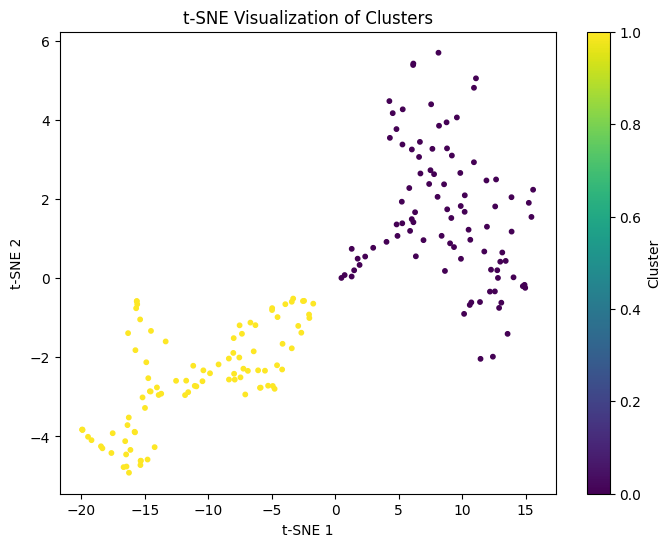

Silhouette Score: 0.6046
Davies-Bouldin Score: 0.5705
Calinski-Harabasz Score: 297.73


In [ ]:
# Step 4: Choose the optimal number of clusters
chosen_k = 2  # You may change this based on the elbow curve

# Step 5: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 6: Apply SMOTE using pseudo-labels
smote = SMOTE(random_state=42)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 7: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 8: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Show a preview
print(result_df.head())
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())

# Step 9: t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 10: Internal validation metrics (no true labels needed)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))

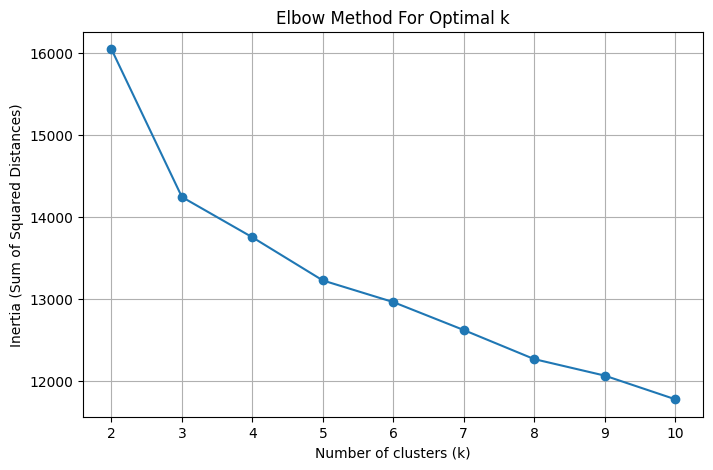

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load your biological unlabeled data
df = pd.read_csv('/content/2_te.csv')  # Make sure this file has no missing values
X = df.values

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Plot the Elbow Method to find optimal n_clusters
inertia = []
k_range = range(2, 11)  # Trying from 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()


   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   1.031554  -0.122734  -1.847635  -0.101522  -0.376944   0.965870   
1  -0.111087  -0.096507  -0.224393   0.741414   0.038498  -0.911934   
2   0.321456   0.418282   1.304836   0.173294   1.361527  -0.454356   
3   0.478890  -0.127087   0.141833   1.134639   0.309515   0.856577   
4  -0.377923  -0.612759   0.056727  -1.171763  -1.136626  -0.872137   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_191  Feature_192  \
0   0.608688  -0.436005  -0.171603  -0.126090  ...     1.043967     0.321979   
1   2.779605   0.103934   0.413012   0.699264  ...     0.763121    -0.544132   
2  -1.171416   1.180961   0.102910   0.767880  ...     0.170306     1.076782   
3   0.112875  -0.163920   0.007373  -0.442091  ...     2.766428     1.166341   
4  -0.064105  -0.217641   1.203890  -0.684994  ...    -0.494332    -1.319896   

   Feature_193  Feature_194  Feature_195  Feature_196  Feature_197  \
0    -1.116432    -1.6

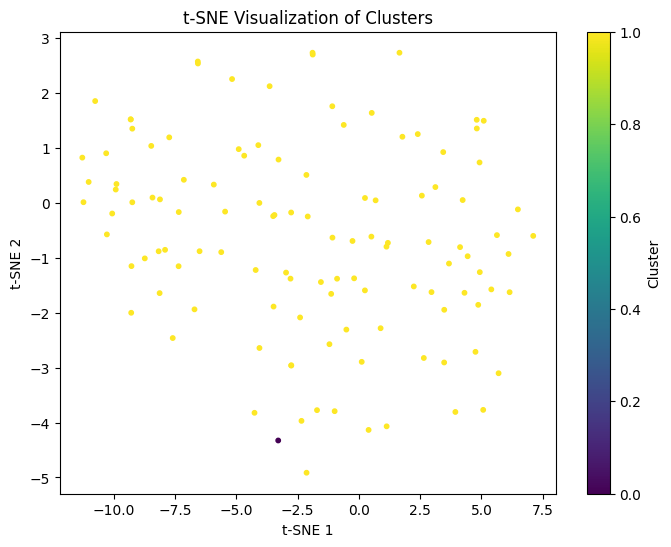

Silhouette Score: 0.0883
Davies-Bouldin Score: 0.8287
Calinski-Harabasz Score: 1.35


In [ ]:
# Step 4: Choose the optimal number of clusters
chosen_k = 2  # You may change this based on the elbow curve

# Step 5: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 6: Apply SMOTE using pseudo-labels
smote = SMOTE(random_state=42)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 7: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 8: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Show a preview
print(result_df.head())
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())

# Step 9: t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 10: Internal validation metrics (no true labels needed)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))

miRNA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the miRNA data
miRNA = pd.read_csv('/content/3_te.csv')

# Normalize the data
scaler_miRNA = StandardScaler()
miRNA_scaled = scaler_miRNA.fit_transform(miRNA)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))

    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)

    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation

    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = miRNA_scaled.shape[1]
autoencoder_miRNA = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder_miRNA.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full dataset
history_miRNA = autoencoder_miRNA.fit(
    miRNA_scaled,
    miRNA_scaled,
    epochs=2000,
    batch_size=64,
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss_miRNA = history_miRNA.history['loss'][-1]  # Get the last training loss
print(f'Training loss for miRNA dataset: {train_loss_miRNA}')


Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2952 - learning_rate: 1.0000e-04
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2859 - learning_rate: 1.0000e-04
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2920 - learning_rate: 1.0000e-04
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2849 - learning_rate: 1.0000e-04
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2917 - learning_rate: 9.9999e-05
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2897 - learning_rate: 9.9999e-05
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2882 - learning_rate: 9.9998e-05
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2901 - learning_rate: 9.9997e-05
Epoch 9/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2891 - learning_rate: 9.9996e-05
Epoch 10/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2832 - learning_rate: 9.9996e-05
Epoch 11/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


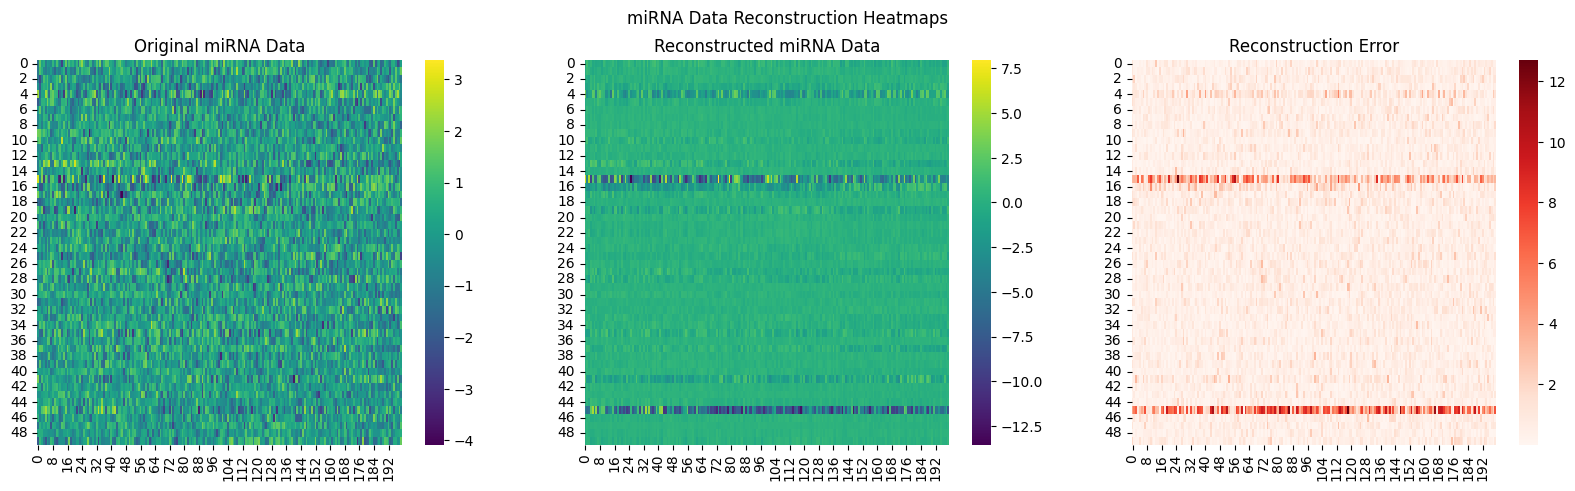

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct the miRNA data using the trained autoencoder
miRNA_reconstructed = autoencoder_miRNA.predict(miRNA_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#miRNA_reconstructed_original = scaler_miRNA.inverse_transform(miRNA_reconstructed)

# Calculate the reconstruction errors
reconstruction_errors_miRNA = np.abs(miRNA_scaled - miRNA_reconstructed)

def plot_combined_heatmaps(original, reconstructed, errors, title):
    # Create a combined heatmap for original data, reconstructed data, and errors
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.heatmap(original[:50], ax=axes[0], cmap='viridis', cbar=True)
    axes[0].set_title('Original miRNA Data')

    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis', cbar=True)
    axes[1].set_title('Reconstructed miRNA Data')

    sns.heatmap(errors[:50], ax=axes[2], cmap='Reds', cbar=True)
    axes[2].set_title('Reconstruction Error')

    plt.suptitle(title)
    plt.show()

# Plot the heatmaps for the miRNA dataset
plot_combined_heatmaps(miRNA_scaled, miRNA_reconstructed, reconstruction_errors_miRNA, 'miRNA Data Reconstruction Heatmaps')


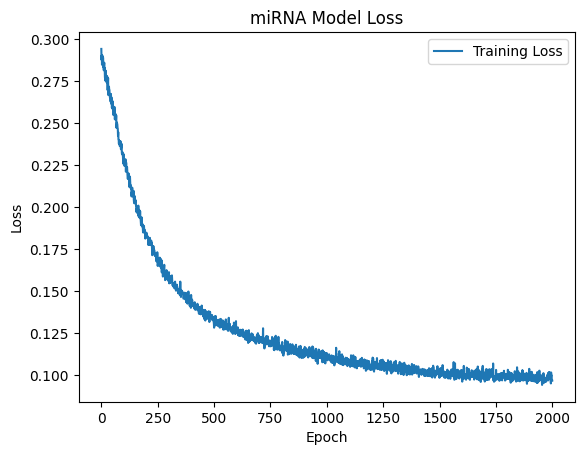

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_miRNA(history_miRNA):
    # Plot training loss
    plt.plot(history_miRNA.history['loss'], label='Training Loss')

    plt.title('miRNA Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Assuming history_miRNA is the variable holding the training history for miRNA
plot_loss_miRNA(history_miRNA)


In [ ]:
# Reconstruct the test data for miRNA
X_test_reconstructed_miRNA = autoencoder_miRNA.predict(miRNA_scaled)

# Convert back to the original scale for miRNA
#X_test_reconstructed_original_miRNA = scaler_miRNA.inverse_transform(X_test_reconstructed_miRNA)

# Save the reconstructed dataset to a CSV file
reconstructed_miRNA_df = pd.DataFrame(X_test_reconstructed_miRNA, columns=miRNA.columns)
reconstructed_miRNA_df.to_csv('reconstructed_miRNA_3te.csv', index=False)

print("Reconstructed dataset saved to 'reconstructed_miRNA.csv'.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Reconstructed dataset saved to 'reconstructed_miRNA.csv'.


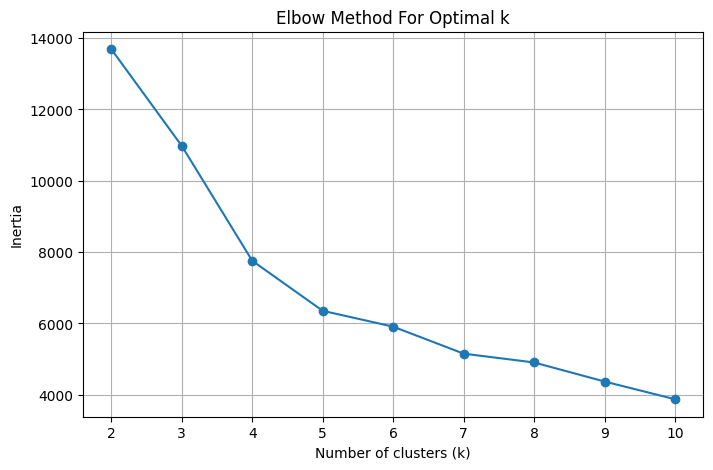

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('reconstructed_miRNA_3te.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


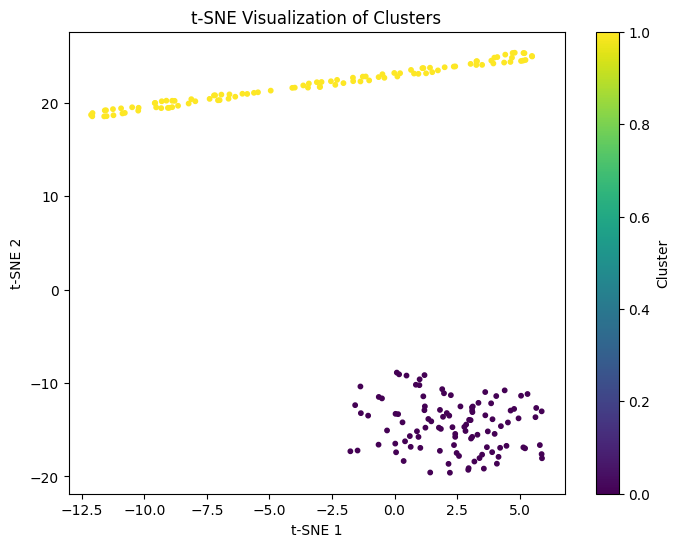


Cluster Counts:
 Cluster
0    103
1    103
Name: count, dtype: int64
Silhouette Score: 0.8463
Davies-Bouldin Score: 0.2145
Calinski-Harabasz Score: 2247.6146


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load your data (replace with your actual data loading)
# Example: df = pd.read_csv('your_file.csv')
# Here we assume 'df' is already available

# Step 2: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

# Step 3: Choose the number of clusters (manually or using elbow method)
chosen_k = 2  # Adjust if needed

# Step 4: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 5: Apply SMOTE using pseudo-labels (set k_neighbors=1 to avoid small sample issue)
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 6: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 7: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Step 8: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 9: Internal validation metrics (unsupervised)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

# Show results
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))


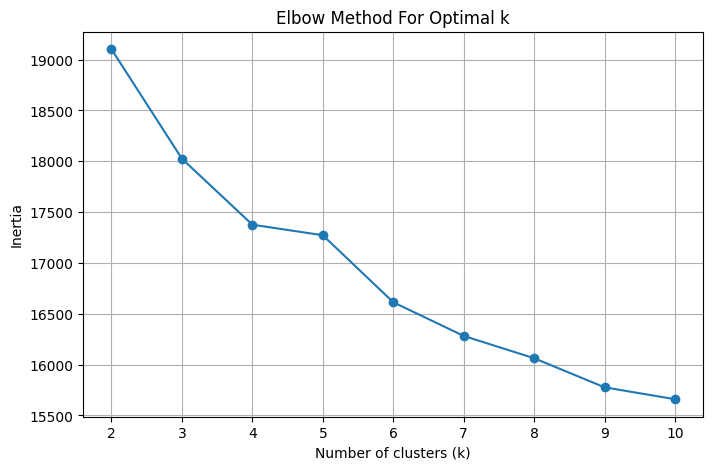

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('/content/3_te.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


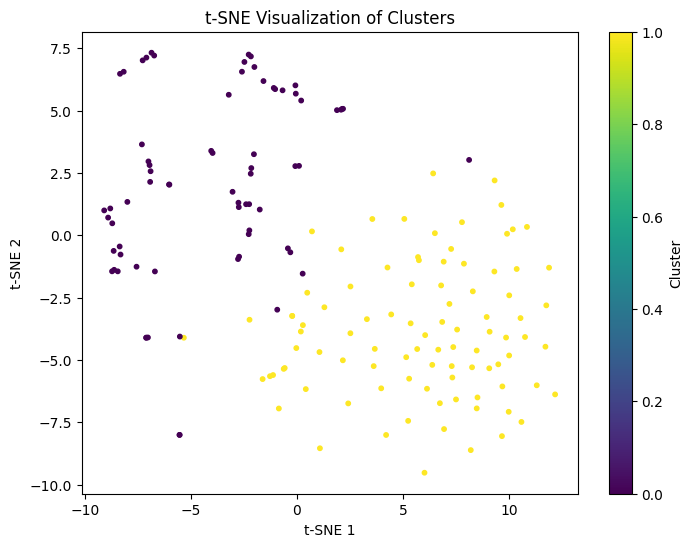


Cluster Counts:
 Cluster
1    93
0    71
Name: count, dtype: int64
Silhouette Score: 0.1203
Davies-Bouldin Score: 2.583
Calinski-Harabasz Score: 23.1983


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load your data (replace with your actual data loading)
# Example: df = pd.read_csv('your_file.csv')
# Here we assume 'df' is already available

# Step 2: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

# Step 3: Choose the number of clusters (manually or using elbow method)
chosen_k = 2  # Adjust if needed

# Step 4: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 5: Apply SMOTE using pseudo-labels (set k_neighbors=1 to avoid small sample issue)
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 6: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 7: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Step 8: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 9: Internal validation metrics (unsupervised)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

# Show results
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))


Concatenated reconstruction dataset saved to 'concatenated_reconstruction_omics.csv'.


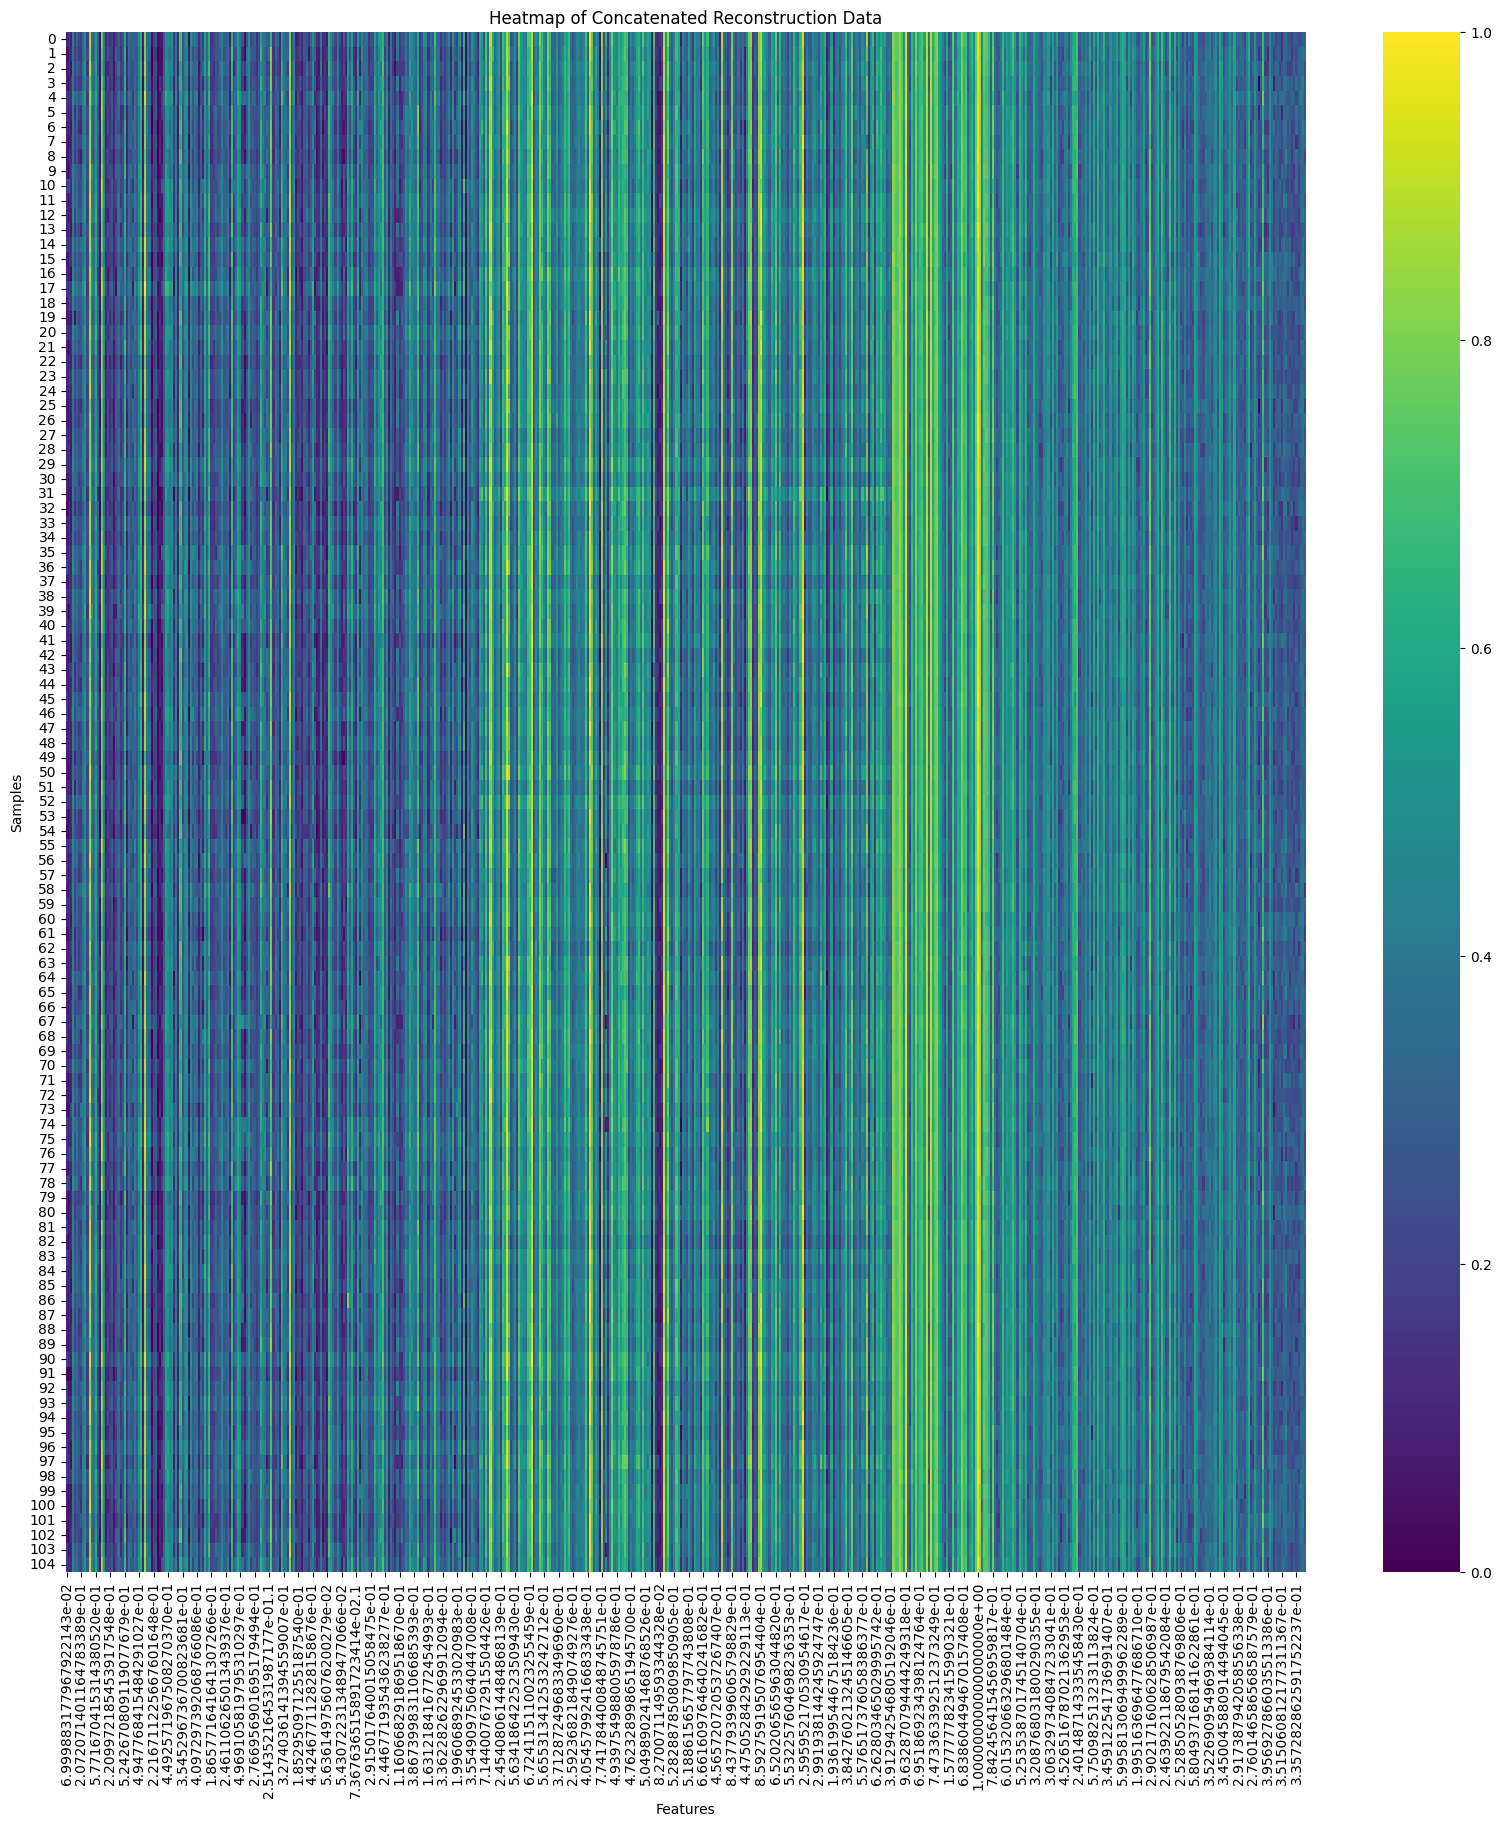

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate the reconstructed datasets
concatenated_reconstruction = pd.concat(
    [meth, mRNA, miRNA],
    axis=1,
    #keys=["Meth", "mRNA", "miRNA"]
)

# Save the concatenated dataset to a CSV file
concatenated_reconstruction.to_csv("Multiomics.csv", index=False)
print("Concatenated reconstruction dataset saved to 'concatenated_reconstruction_omics.csv'.")

# Visualize the heatmap of the concatenated data (taking the first 2503 samples)
plt.figure(figsize=(20, 20))
sns.heatmap(concatenated_reconstruction.iloc[:2503], cmap="viridis")  # No transpose, features on x-axis, samples on y-axis
plt.title("Heatmap of Concatenated Reconstruction Data")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()


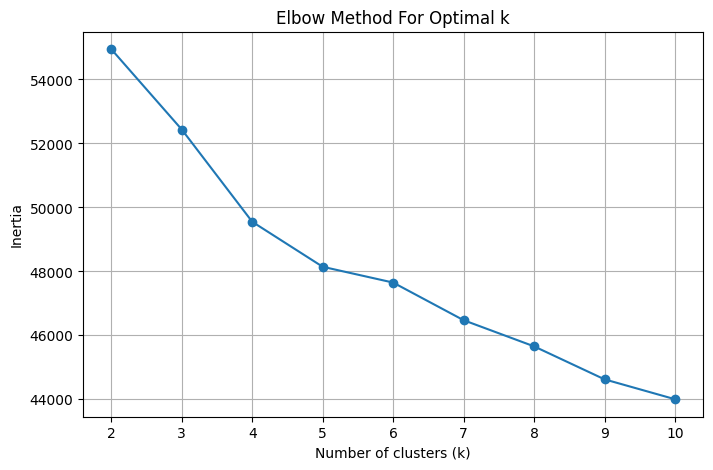

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('Multiomics.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


   6.999883177967922143e-02  1.713576083221808877e-01  \
0                 -0.701723                  1.614739   
1                 -1.701847                 -0.360800   
2                 -1.365279                  0.469812   
3                 -0.934232                 -0.880068   
4                  1.027378                  0.890523   

   5.011166302604544431e-02  4.834501703339517675e-01  \
0                 -0.840308                 -0.201104   
1                  0.607102                 -1.442400   
2                 -1.445695                 -0.086844   
3                  0.795943                 -0.946051   
4                  0.780551                  0.774229   

   2.839510685700721293e-01  3.371600643017752530e-01  \
0                 -0.758224                 -0.053310   
1                 -0.857510                 -1.250248   
2                 -0.422254                  0.043348   
3                 -1.138427                 -1.739166   
4                  1.131512  

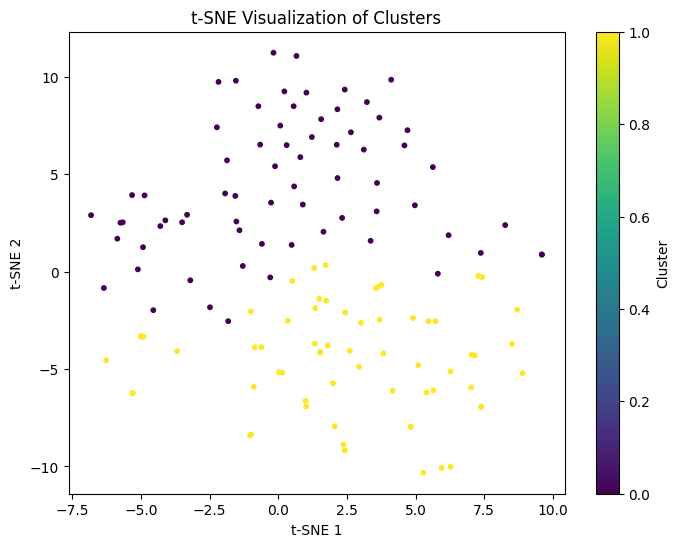


Internal Validation Metrics:
Silhouette Score: 0.1298
Davies-Bouldin Score: 2.3727
Calinski-Harabasz Score: 22.7115

Top Biomarker Candidates (based on Kruskal-Wallis test):
                      Feature    ANOVA_pval  Kruskal_pval
145  4.049951892415447618e-01  7.936513e-32  3.417344e-21
138  5.997184389359950796e-01  4.403587e-28  5.421555e-20
128  5.248828689966622552e-01  1.833580e-25  1.231505e-19
9    5.408901800057888121e-01  3.290635e-22  6.466179e-19
5    3.371600643017752530e-01  2.308145e-22  1.043785e-18
63   4.097297392068766086e-01  5.762258e-21  2.368105e-17
78   4.113377910869065457e-01  3.342682e-20  2.507618e-17
137  3.461708281837749257e-01  1.528873e-19  6.006078e-17
148  2.282475788005146888e-01  2.358253e-20  6.845977e-17
154  2.446771935436238277e-01  4.754134e-20  7.668908e-17
100  2.423546118210627986e-01  1.667966e-18  1.073868e-16
35   4.947768415484291027e-01  1.793767e-20  1.204085e-16
38   8.406748925072650147e-01  1.389165e-18  1.346921e-16
105  3.274036

/tmp/ipython-input-38-2109771919.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Cluster'] = result_df['Cluster'].values


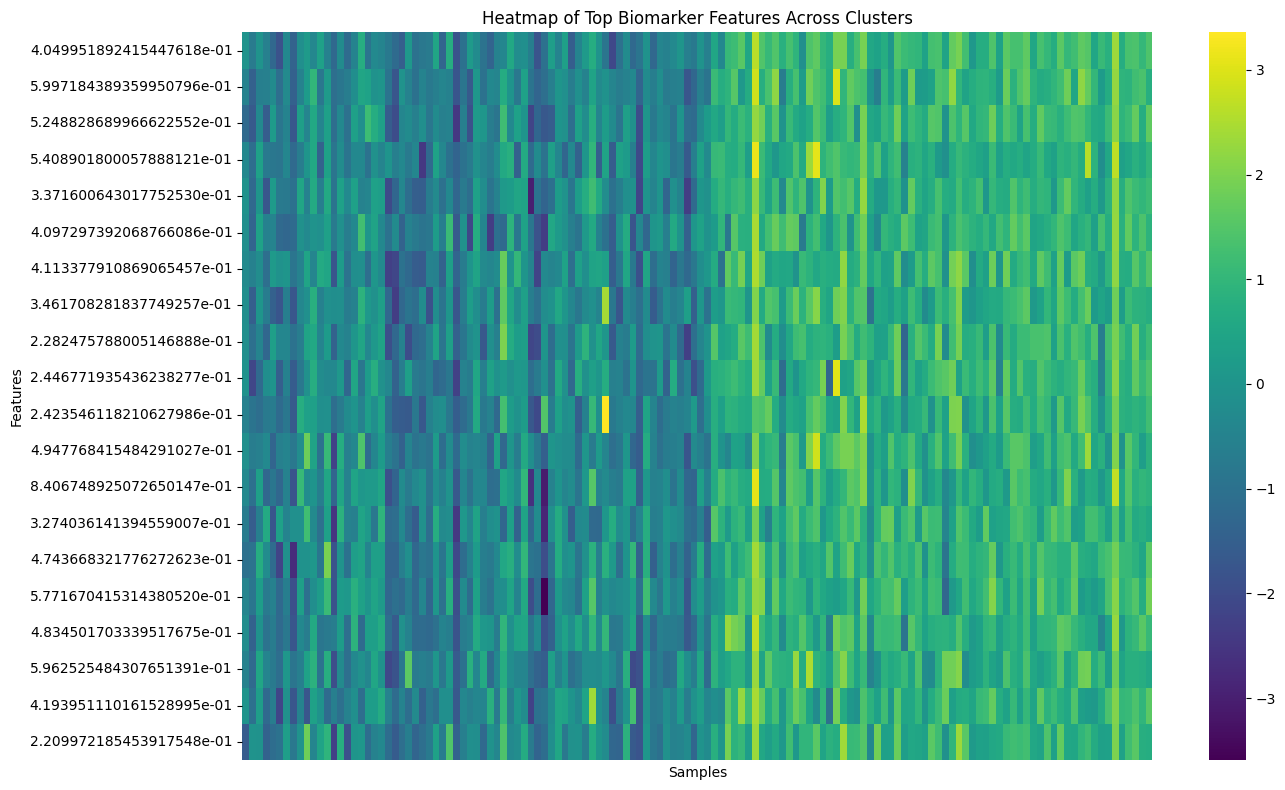

In [ ]:
# Step 4: Choose number of clusters
chosen_k = 2  # adjust based on elbow plot

# Step 5: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 6: Apply SMOTE on pseudo-labels
smote = SMOTE(random_state=42)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 7: Final clustering on SMOTE data
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 8: Create DataFrame with biological feature names and cluster labels
result_df = pd.DataFrame(X_smote, columns=df.columns)  # preserve real feature names here
result_df['Cluster'] = final_clusters

print(result_df.head())
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())

# Step 9: t-SNE visualization of clusters
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 10: Internal cluster validation scores
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

print("\nInternal Validation Metrics:")
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))

# Step 11: Biomarker discovery (differential features across clusters)
X_biomarker = result_df.drop('Cluster', axis=1).values
y_clusters = result_df['Cluster'].values

anova_pvals = []
kruskal_pvals = []

for i in range(X_biomarker.shape[1]):
    groups = [X_biomarker[y_clusters == c, i] for c in np.unique(y_clusters)]

    # ANOVA
    try:
        _, p_anova = f_oneway(*groups)
    except:
        p_anova = 1.0
    anova_pvals.append(p_anova)

    # Kruskal-Wallis
    try:
        _, p_kruskal = kruskal(*groups)
    except:
        p_kruskal = 1.0
    kruskal_pvals.append(p_kruskal)

biomarker_df = pd.DataFrame({
    'Feature': df.columns,  # use original biological names here
    'ANOVA_pval': anova_pvals,
    'Kruskal_pval': kruskal_pvals
})

biomarker_df.sort_values('Kruskal_pval', inplace=True)

print("\nTop Biomarker Candidates (based on Kruskal-Wallis test):")
print(biomarker_df.head(20))

# Step 12: Print only top biomarker names
top_n = 20
top_biomarkers = biomarker_df.head(top_n)['Feature'].values

print("\nTop Biomarker Feature Names:")
for name in top_biomarkers:
    print(name)

# Step 13: Heatmap of top biomarkers across samples sorted by cluster
top_features = biomarker_df.head(top_n)['Feature'].values
heatmap_data = result_df[top_features]
heatmap_data['Cluster'] = result_df['Cluster'].values
heatmap_data_sorted = heatmap_data.sort_values('Cluster')
cluster_labels = heatmap_data_sorted['Cluster']
heatmap_data_sorted = heatmap_data_sorted.drop('Cluster', axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data_sorted.T, cmap='viridis', cbar=True, xticklabels=False)
plt.title("Heatmap of Top Biomarker Features Across Clusters")
plt.xlabel("Samples")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

New Section

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import math

# Load the data
meth = pd.read_csv('/content/Multiomics.csv')

# Normalize the data
scaler = StandardScaler()
meth_scaled = scaler.fit_transform(meth)

# Define the autoencoder model
def create_denoising_autoencoder(input_dim, regularization=1e-6, dropout_rate=0.3, noise_factor=0.3):
    input_layer = Input(shape=(input_dim,))

    # Add Gaussian Noise for denoising
    noisy_input = GaussianNoise(noise_factor)(input_layer)

    # Encoder
    encoded = Dense(512, activation='relu', kernel_regularizer=l2(regularization))(noisy_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    encoded = Dense(64, activation='relu', activity_regularizer=l1(1e-5))(encoded)  # Sparse representation

    # Decoder
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(regularization))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(256, activation='relu', kernel_regularizer=l2(regularization))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

# Define the autoencoder model
input_dim = meth_scaled.shape[1]
autoencoder = create_denoising_autoencoder(input_dim)

# Compile the autoencoder model with MSLE loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredLogarithmicError())

# Define the cosine annealing learning rate scheduler
def cosine_annealing(epoch, lr, initial_lr=0.0001, min_lr=1e-5, T=2000):
    """Cosine annealing learning rate schedule."""
    cos_inner = (math.pi * (epoch % T)) / T
    return min_lr + (initial_lr - min_lr) * (1 + math.cos(cos_inner)) / 2

lr_schedule = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, T=2000))

# Train the autoencoder on the full dataset
history = autoencoder.fit(
    meth_scaled,
    meth_scaled,
    epochs=2000,
    batch_size=64,
    callbacks=[lr_schedule]
)

# Print the final training loss
train_loss = history.history['loss'][-1]
print(f'Training loss: {train_loss}')


Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.2472 - learning_rate: 1.0000e-04
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2445 - learning_rate: 1.0000e-04
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2458 - learning_rate: 9.9999e-05
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2383 - learning_rate: 9.9999e-05
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2416 - learning_rate: 9.9998e-05
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2415 - learning_rate: 9.9997e-05
Epoch 9/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2395 - learning_rate: 9.9996e-05
Epoch 10/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2432 - learning_rate: 9.9996e-05
Epoch 11/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


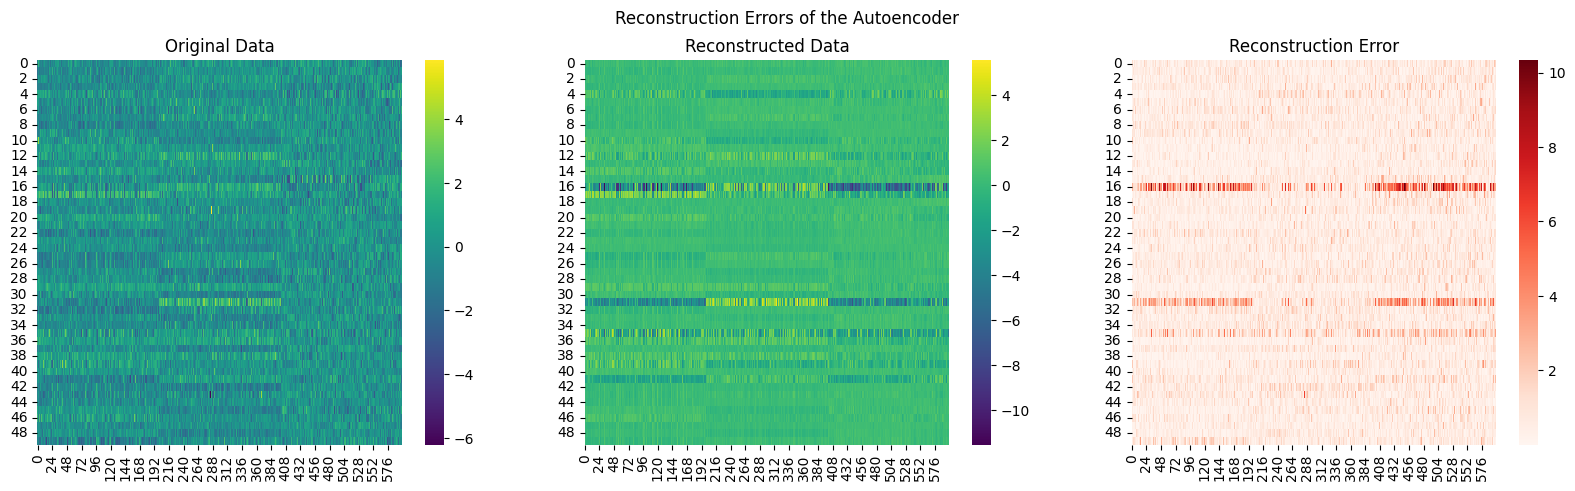

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the reconstructed data from the autoencoder
X_reconstructed = autoencoder.predict(meth_scaled)

# Calculate reconstruction errors (absolute difference between original and reconstructed data)
reconstruction_errors = np.abs(meth_scaled - X_reconstructed)

# Define a function to plot the combined heatmaps
def plot_combined_heatmaps(original, reconstructed, errors, title):
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the heatmap for the original data
    sns.heatmap(original[:50], ax=axes[0], cmap='viridis')
    axes[0].set_title('Original Data')

    # Plot the heatmap for the reconstructed data
    sns.heatmap(reconstructed[:50], ax=axes[1], cmap='viridis')
    axes[1].set_title('Reconstructed Data')

    # Plot the heatmap for the reconstruction error
    sns.heatmap(errors[:50], ax=axes[2], cmap='Reds')
    axes[2].set_title('Reconstruction Error')

    # Set the main title for the entire plot
    plt.suptitle(title)

    # Display the plot
    plt.show()

# Plot the heatmaps for the first 50 samples of each dataset
plot_combined_heatmaps(meth_scaled, X_reconstructed, reconstruction_errors, 'Reconstruction Errors of the Autoencoder')


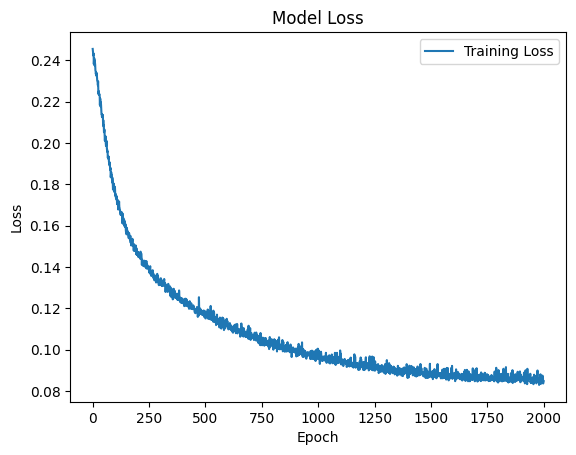

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):

    plt.plot(history.history['loss'], label='Training Loss')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


plot_loss(history)


In [ ]:
# Reconstruct the test data (using the trained autoencoder)
X_reconstructed = autoencoder.predict(meth_scaled)

# Convert the reconstructed data back to the original scale using the scaler
#X_reconstructed_original = scaler.inverse_transform(X_reconstructed)

# Save the reconstructed dataset to a CSV file
reconstructed_df = pd.DataFrame(X_reconstructed, columns=meth.columns)
reconstructed_df.to_csv('reconstructed_Multiomics_te.csv', index=False)

print("Reconstructed dataset saved to 'reconstructed_meth.csv'.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Reconstructed dataset saved to 'reconstructed_meth.csv'.


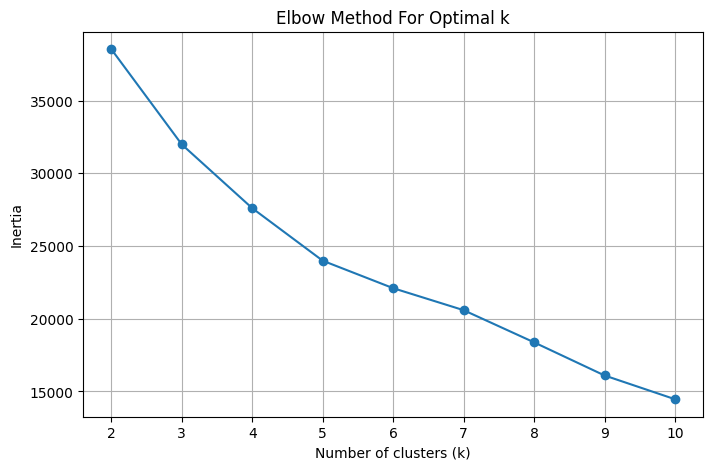

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data
df = pd.read_csv('reconstructed_Multiomics_te.csv')  # Rows: samples, Columns: features (no true labels)
X = df.values

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


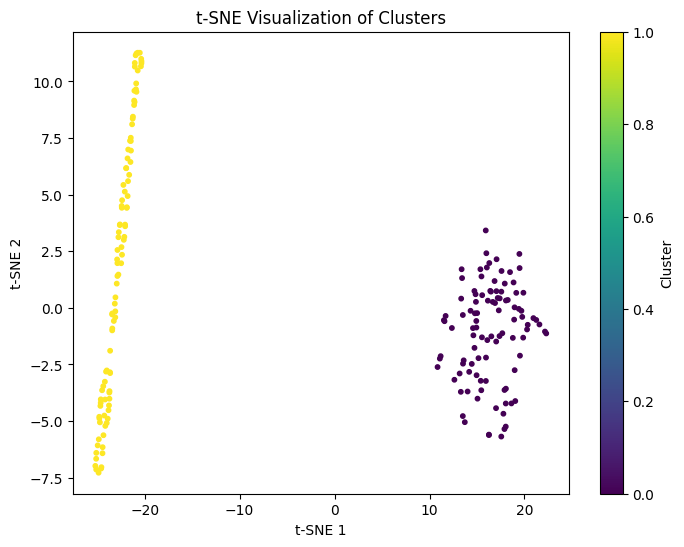


Cluster Counts:
 Cluster
0    102
1    102
Name: count, dtype: int64
Silhouette Score: 0.6937
Davies-Bouldin Score: 0.4787
Calinski-Harabasz Score: 614.3077


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Load your data (replace with your actual data loading)
# Example: df = pd.read_csv('your_file.csv')
# Here we assume 'df' is already available

# Step 2: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

# Step 3: Choose the number of clusters (manually or using elbow method)
chosen_k = 2  # Adjust if needed

# Step 4: Initial clustering to get pseudo-labels
initial_kmeans = KMeans(n_clusters=chosen_k, random_state=42)
pseudo_labels = initial_kmeans.fit_predict(X_scaled)

# Step 5: Apply SMOTE using pseudo-labels (set k_neighbors=1 to avoid small sample issue)
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, pseudo_labels_smote = smote.fit_resample(X_scaled, pseudo_labels)

# Step 6: Re-cluster after SMOTE using same chosen_k
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
final_clusters = kmeans_final.fit_predict(X_smote)

# Step 7: Save result with cluster labels
result_df = pd.DataFrame(X_smote, columns=[f'Feature_{i}' for i in range(X_smote.shape[1])])
result_df['Cluster'] = final_clusters

# Step 8: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(result_df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=result_df['Cluster'], cmap='viridis', s=10)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 9: Internal validation metrics (unsupervised)
silhouette = silhouette_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
db_score = davies_bouldin_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])
ch_score = calinski_harabasz_score(result_df.drop('Cluster', axis=1), result_df['Cluster'])

# Show results
print("\nCluster Counts:\n", result_df['Cluster'].value_counts())
print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))
print("Calinski-Harabasz Score:", round(ch_score, 4))
